# Libray matching with DreaMS

TODO: text

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from rdkit import Chem
import dreams.utils.spectra as su
import dreams.utils.io as io
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.data import MSData
from dreams.api import compute_dreams_embeddings
%reload_ext autoreload
%autoreload 2

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
in_pth = Path('../data/pipers2021/20210623_08_3A_1uL.mzML')
lib_pth = Path('../data/MassSpecGym_DreaMS.hdf5')

In [3]:
msdata_lib = MSData.load(lib_pth)
embs_lib = msdata_lib['DreaMS_embedding']
embs_lib.shape

(213548, 1024)

In [4]:
embs = compute_dreams_embeddings(in_pth)
msdata = MSData.load(in_pth.with_suffix('.hdf5'))
embs.shape

Computing DreaMS embedding: 100%|██████████| 8103/8103 [03:15<00:00, 41.50it/s]


(8103, 1024)

In [5]:
sims = cosine_similarity(embs, embs_lib)
sims.shape

(8103, 213548)

In [6]:
k = 5
topk_cands = np.argsort(sims, axis=1)[:, -k:][:, ::-1]
topk_cands.shape

(8103, 5)

In [110]:
np.argmax(sims, axis=1)

array([ 59206,  50967,  45918, ..., 157655,   1423,  93123])

In [7]:
# Construct a DataFrame with the top-k candidates and their similarities
df = []
cos_sim = su.PeakListModifiedCosine()
for i, topk in enumerate(tqdm(topk_cands)):
    for n, j in enumerate(topk):
        df.append({
            'feature_id': i + 1,
            'topk': n + 1,
            'library_j': j,
            'library_SMILES': msdata_lib.get_smiles(j),
            'library_ID': msdata_lib.get_values('IDENTIFIER', j),
            'DreaMS_similarity': sims[i, j],
            'Modified_cosine_similarity': cos_sim(
                spec1=msdata.get_spectra(i),
                prec_mz1=msdata.get_prec_mzs(i),
                spec2=msdata_lib.get_spectra(j),
                prec_mz2=msdata_lib.get_prec_mzs(j),
            ),
            'i': i,
            'j': j,
        })
df = pd.DataFrame(df)

# Sort hits by DreaMS similarity
df_top1 = df[df['topk'] == 1].sort_values('DreaMS_similarity', ascending=False)
df = df.set_index('feature_id').loc[df_top1['feature_id'].values].reset_index()
df

100%|██████████| 8103/8103 [01:11<00:00, 112.87it/s]


,feature_id,topk,library_j,library_SMILES,library_ID,DreaMS_similarity,Modified_cosine_similarity,i,j
0,4154,1,28842,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036768,0.958525,0.993251,4153,28842
1,4154,2,28949,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036902,0.952289,0.922711,4153,28949
2,4154,3,28928,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036876,0.948801,0.945801,4153,28928
3,4154,4,28869,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036800,0.947673,0.972351,4153,28869
4,4154,5,28931,C1CCN(CC1)C(=O)/C=C/C=C/C2=CC3=C(C=C2)OCO3,MassSpecGymID0036880,0.946521,0.958158,4153,28931
...,...,...,...,...,...,...,...,...,...
40510,6112,1,113562,C([C@H]([C@@H]([C@@H]([C@H](CO)O)O)O)O)O,MassSpecGymID0176912,0.330335,0.113459,6111,113562
40511,6112,2,71515,C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O,MassSpecGymID0095601,0.324613,0.074090,6111,71515
40512,6112,3,141721,CN(CC(=O)N(CC1=CC=C(C=C1)C2CCCCC2)C3=CC=C(C=C3...,MassSpecGymID0219026,0.324235,0.005257,6111,141721
40513,6112,4,141726,CN(CC(=O)N(CC1=CC=C(C=C1)C2CCCCC2)C3=CC=C(C=C3...,MassSpecGymID0219031,0.315426,0.005273,6111,141726


In [12]:
df.to_csv(io.append_to_stem(in_pth, 'MassSpecGym_hits').with_suffix('.csv'), index=False)

### Examples

Library ID: MassSpecGymID0178797 (top 1 hit)
Query precursor m/z: 330.170074462891, Library precursor m/z: 330.17
DreaMS similarity: 0.9432377815246582
Modified cosine similarity: 0.8671759651306155


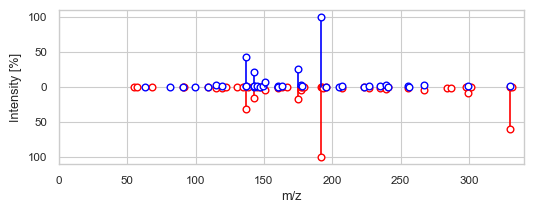

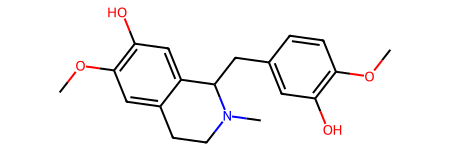

Library ID: MassSpecGymID0188561 (top 2 hit)
Query precursor m/z: 330.170074462891, Library precursor m/z: 330.17
DreaMS similarity: 0.900348424911499
Modified cosine similarity: 0.953118861061558


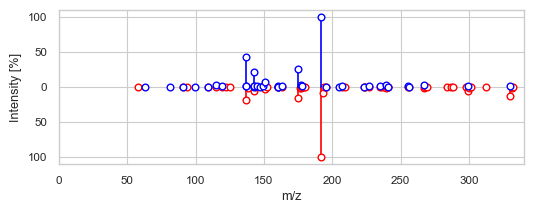

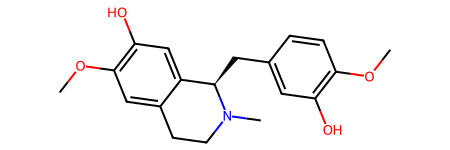

Library ID: MassSpecGymID0188562 (top 3 hit)
Query precursor m/z: 330.170074462891, Library precursor m/z: 330.17
DreaMS similarity: 0.9003483653068542
Modified cosine similarity: 0.9531188613574908


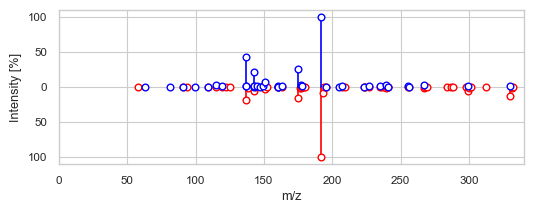

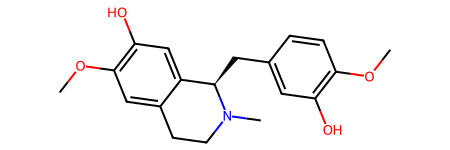

Library ID: MassSpecGymID0178792 (top 4 hit)
Query precursor m/z: 330.170074462891, Library precursor m/z: 330.1705
DreaMS similarity: 0.7679221630096436
Modified cosine similarity: 0.6460437573182453


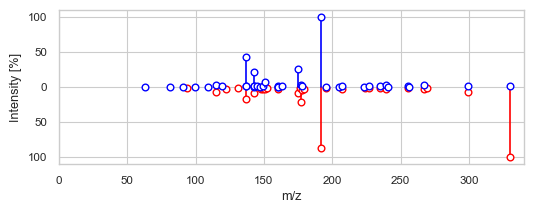

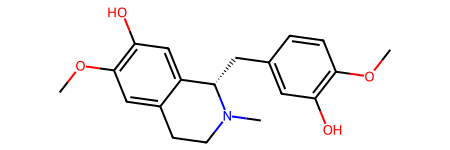

Library ID: MassSpecGymID0188563 (top 5 hit)
Query precursor m/z: 330.170074462891, Library precursor m/z: 330.17
DreaMS similarity: 0.7564510107040405
Modified cosine similarity: 0.40597307035112


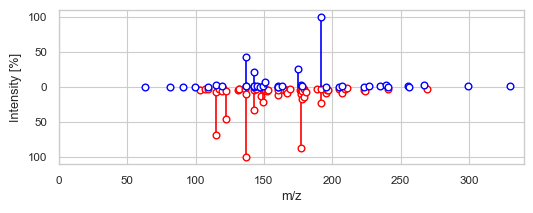

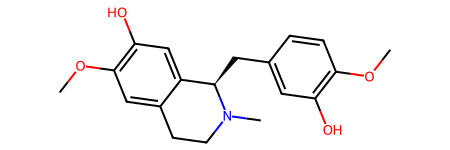

In [117]:
i = df_top1['i'].iloc[6]
df_i = df[df['i'] == i]
for _, row in df_i.iterrows():
    i, j = row['i'], row['j']
    print(f'Library ID: {row["library_ID"]} (top {row["topk"]} hit)')
    print(f'Query precursor m/z: {msdata.get_prec_mzs(i)}, Library precursor m/z: {msdata_lib.get_prec_mzs(j)}')
    print('DreaMS similarity:', row['DreaMS_similarity'])
    print('Modified cosine similarity:', row['Modified_cosine_similarity'])
    su.plot_spectrum(spec=msdata.get_spectra(i), mirror_spec=msdata_lib.get_spectra(j))
    display(Chem.MolFromSmiles(row['library_SMILES']))

Library ID: MassSpecGymID0060343 (top 1 hit)
Query precursor m/z: 113.963943481445, Library precursor m/z: 114.0914
DreaMS similarity: 0.5377157926559448
Modified cosine similarity: 0.0026405732513553296


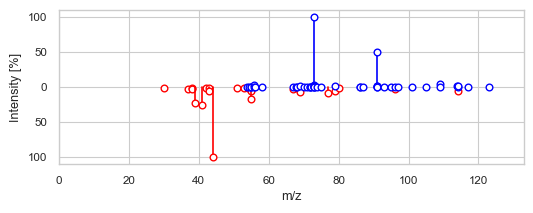

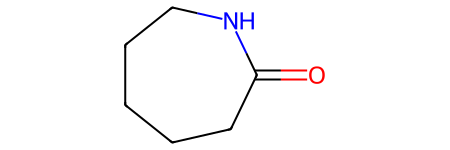

Library ID: MassSpecGymID0060346 (top 2 hit)
Query precursor m/z: 113.963943481445, Library precursor m/z: 114.0914
DreaMS similarity: 0.5122054219245911
Modified cosine similarity: 0.008046819899476667


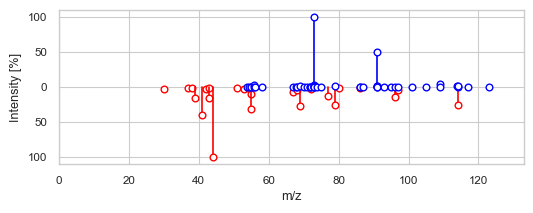

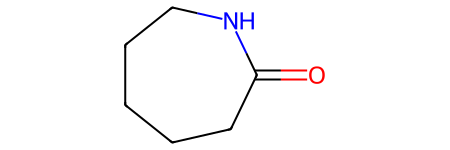

Library ID: MassSpecGymID0220743 (top 3 hit)
Query precursor m/z: 113.963943481445, Library precursor m/z: 174.11247
DreaMS similarity: 0.4986434578895569
Modified cosine similarity: 0.012097934704344188


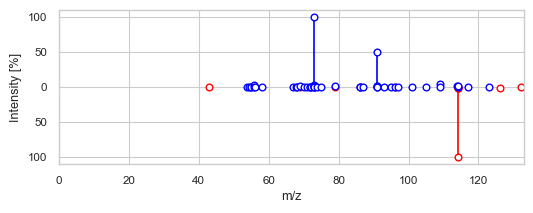

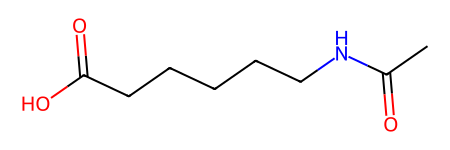

Library ID: MassSpecGymID0071076 (top 4 hit)
Query precursor m/z: 113.963943481445, Library precursor m/z: 156.1019
DreaMS similarity: 0.4957997798919678
Modified cosine similarity: 0.006503985272453359


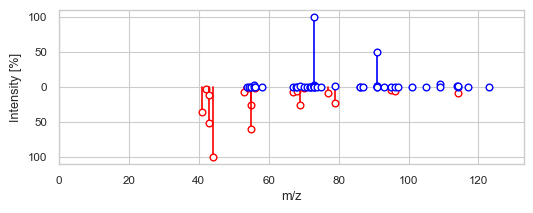

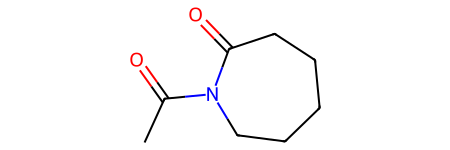

Library ID: MassSpecGymID0091523 (top 5 hit)
Query precursor m/z: 113.963943481445, Library precursor m/z: 282.2791
DreaMS similarity: 0.49230116605758667
Modified cosine similarity: 0.016895436102017856


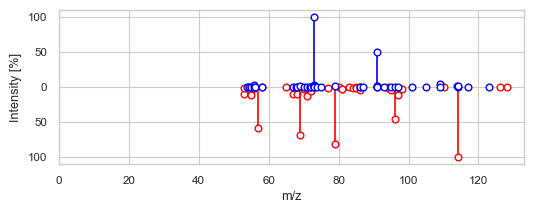

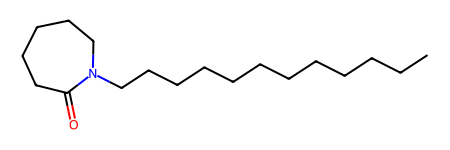

In [16]:
i = 2
df_i = df[df['i'] == i]
for _, row in df_i.iterrows():
    i, j = row['i'], row['j']
    print(f'Library ID: {row["library_ID"]} (top {row["topk"]} hit)')
    print(f'Query precursor m/z: {msdata.get_prec_mzs(i)}, Library precursor m/z: {msdata_lib.get_prec_mzs(j)}')
    print('DreaMS similarity:', row['DreaMS_similarity'])
    print('Modified cosine similarity:', row['Modified_cosine_similarity'])
    su.plot_spectrum(spec=msdata.get_spectra(i), mirror_spec=msdata_lib.get_spectra(j))
    display(Chem.MolFromSmiles(row['library_SMILES']))

In [11]:
cos_sim = PeakListModifiedCosine()
cos_sim.compute_pairwise(specs=msdata_lib['spectrum'][df_i['library_j']], prec_mzs=msdata_lib['precursor_mz'][df_i['library_j']], avg=False)

array([[1.        , 0.9774837 , 0.66585165, 0.67379465, 0.98394397],
       [0.9774837 , 1.        , 0.77432333, 0.78076812, 0.99617282],
       [0.66585165, 0.77432333, 1.        , 0.99944986, 0.75433974],
       [0.67379465, 0.78076812, 0.99944986, 1.        , 0.76193796],
       [0.98394397, 0.99617282, 0.75433974, 0.76193796, 1.        ]])

## Even faster search via approximate nearest neighbors

[PyNNDescent](https://pynndescent.readthedocs.io/en/latest/index.html)

In [97]:
import pynndescent
index = pynndescent.NNDescent(embs_lib, metric='cosine', n_neighbors=50)

In [107]:
# Approximate nearest neighbors search
neighbors = index.query(embs[[i]])
pd.DataFrame({
    'j': neighbors[0][0],
    'DreaMS_similarity': 1 - neighbors[1][0]  # Convert distances to similarities
})

,j,DreaMS_similarity
0,45918,0.537716
1,45919,0.512205
2,142992,0.498643
3,52806,0.495800
4,68866,0.492301
5,68873,0.491650
6,68872,0.490687
7,45917,0.481273
8,68867,0.481187
9,45920,0.479988


In [109]:
# Exact nearest neighbors search
df_i[['j', 'DreaMS_similarity']]

,j,DreaMS_similarity
29470,45918,0.537716
29471,45919,0.512205
29472,142992,0.498643
29473,52806,0.495800
29474,68866,0.492301
